<a href="https://colab.research.google.com/github/kkarimi62/IBM-Machine-Learning-Professional-Certificate/blob/main/SupervisedMachineLearningClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Space X  Falcon 9 First Stage Landing Prediction**


## Dataset & Attributes

Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if one could determine if the first stage will land, it is possisble to determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch. Here in this project, we use the rocket launch database built from the recordings of Space X Falcon 9 first stage landing. Our objective is to predict whether the first stage will land given the data.

The following information is provided for each record in the dataset:

*   FlightNumber
*   PayloadMass
*   Flights
*   Block
*   ReusedCount
*   Orbit
*   LaunchSite
*   LandingPad
*   Serial
*   GridFins
*   Reused
*   Legs
*   Class


## Main Objectives


Perform supervised binary classification tasks and predict landing outcomes

*   Find best hyperparameter for SVM, classification trees, k-nearest neighbors, and logistic regression
*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


We import the following libraries for the lab


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

This function is used to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

## Load the dataframe


We load the [dataset](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv) and explore its shape and data types.


In [3]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL)

In [4]:
round(data.head(),2)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.96,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.58,28.56,0
1,2,2012-05-22,Falcon 9,525.00,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.58,28.56,0
2,3,2013-03-01,Falcon 9,677.00,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.58,28.56,0
3,4,2013-09-29,Falcon 9,500.00,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.61,34.63,0
4,5,2013-12-03,Falcon 9,3170.00,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.58,28.56,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
 17  Class           90 non-null     int64

Our dataset consists of `90` entries and `18` columns with a mixture of `int`, `float`, `string`, and `bool` types. As a catagorical column, `LandingPad` contains `NaNs` associated with it, which can be properly treated by using the `LabelEncoder` functioality in `sklearn`, with `NaNs` classified as a disticnt class.

## Pre-processing and feature selection:

Encode data

In [6]:
non_numerical_columns = data.select_dtypes(include=['object','bool']).columns
non_numerical_columns

Index(['Date', 'BoosterVersion', 'Orbit', 'LaunchSite', 'Outcome', 'GridFins',
       'Reused', 'Legs', 'LandingPad', 'Serial'],
      dtype='object')

In [7]:
le = LabelEncoder()
for col in non_numerical_columns:
    data[ col ] = le.fit_transform(data[col])

In [8]:
round(data.describe().T,1)

,count,mean,std,min,25%,50%,75%,max
FlightNumber,90.0,45.5,26.1,1.0,23.2,45.5,67.8,90.0
Date,90.0,44.5,26.1,0.0,22.2,44.5,66.8,89.0
BoosterVersion,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PayloadMass,90.0,6105.0,4694.7,350.0,2510.8,4701.5,8912.8,15600.0
Orbit,90.0,5.0,3.0,0.0,2.0,4.0,7.0,10.0
LaunchSite,90.0,0.5,0.7,0.0,0.0,0.0,1.0,2.0
Outcome,90.0,4.7,1.7,0.0,4.0,5.0,5.0,7.0
Flights,90.0,1.8,1.2,1.0,1.0,1.0,2.0,6.0
GridFins,90.0,0.8,0.4,0.0,1.0,1.0,1.0,1.0
Reused,90.0,0.4,0.5,0.0,0.0,0.0,1.0,1.0



We further standardize the data in <code>feauture_columns</code> then reassign it to the associated columns using the transform provided below. Here `FlightNumber`, `Date`, and `BoosterVersion` are not included as `feauture_columns`.


In [9]:
feauture_columns = data.columns[3:-1]
print('feauture_columns:',feauture_columns)

mm = MinMaxScaler()
for col in feauture_columns:
    data[col] = mm.fit_transform(data[col].to_numpy().reshape( -1, 1))

feauture_columns: Index(['PayloadMass', 'Orbit', 'LaunchSite', 'Outcome', 'Flights', 'GridFins',
       'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial',
       'Longitude', 'Latitude'],
      dtype='object')


In [10]:
round(data[feauture_columns].describe().T,1)

,count,mean,std,min,25%,50%,75%,max
PayloadMass,90.0,0.4,0.3,0.0,0.1,0.3,0.6,1.0
Orbit,90.0,0.5,0.3,0.0,0.2,0.4,0.7,1.0
LaunchSite,90.0,0.3,0.4,0.0,0.0,0.0,0.5,1.0
Outcome,90.0,0.7,0.2,0.0,0.6,0.7,0.7,1.0
Flights,90.0,0.2,0.2,0.0,0.0,0.0,0.2,1.0
GridFins,90.0,0.8,0.4,0.0,1.0,1.0,1.0,1.0
Reused,90.0,0.4,0.5,0.0,0.0,0.0,1.0,1.0
Legs,90.0,0.8,0.4,0.0,1.0,1.0,1.0,1.0
LandingPad,90.0,0.6,0.4,0.0,0.4,0.4,1.0,1.0
Block,90.0,0.6,0.4,0.0,0.2,0.8,1.0,1.0


We Create NumPy arrays from <code>Class</code> and <code>feauture_columns</code>, by applying the method <code>to_numpy()</code>  then
assign them to `X` and <code>Y</code>.

In [11]:
X = data[feauture_columns].to_numpy()
Y = data.Class.to_numpy()

*We* split the data into training and testing data using the  function  <code>train_test_split</code>. The parameter `test_size` is set  `0.25` and `random_state` to `128`.

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=256, stratify=Y)

By passing `stratify=Y` as the function argument, we ensure to maintain the proportion associated with `0` and `1` labels within `Y_train` and `Y_test`.

In [25]:
pd.DataFrame(Y_test).value_counts(normalize=True)

1    0.652174
0    0.347826
Name: proportion, dtype: float64

In [26]:
pd.DataFrame(Y_train).value_counts(normalize=True)

1    0.671642
0    0.328358
Name: proportion, dtype: float64

## logistic regression


We create a logistic regression object  then create a  `GridSearchCV` object  <code>logreg_cv</code> with `cv = 10`.  We Fit the object to find the best hyperparameters from the dictionary <code>parameters</code>.
We include the `l2` regularization and `lbfgs` solver.

In [27]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [28]:
lr        = LogisticRegression()
logreg_cv = GridSearchCV(lr,parameters,cv=10)
logreg_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression and display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the training data using the data attribute <code>best_score\_</code>.


In [29]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8952380952380953


we also calculate the accuracy on the test data using the method <code>score</code>:


In [30]:
test_accuracy = logreg_cv.score(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8695652173913043


Here is the confusion matrix:


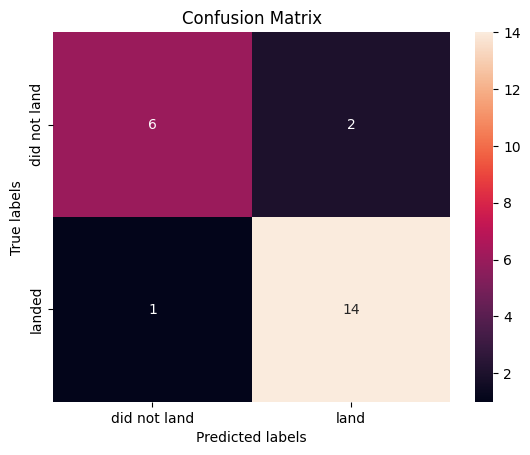

In [31]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.




## SVM


We create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with `cv = 10`.  We fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [38]:
parameters = {'kernel':('rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [39]:
svm_cv = GridSearchCV(svm,parameters,cv=10)
svm_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('rbf', 'poly', 'rbf', 'sigmoid')})

In [40]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.9857142857142858


We calculate the accuracy on the test data using the method <code>score</code>:


In [41]:
test_accuracy = svm_cv.score(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9565217391304348


We can plot the confusion matrix


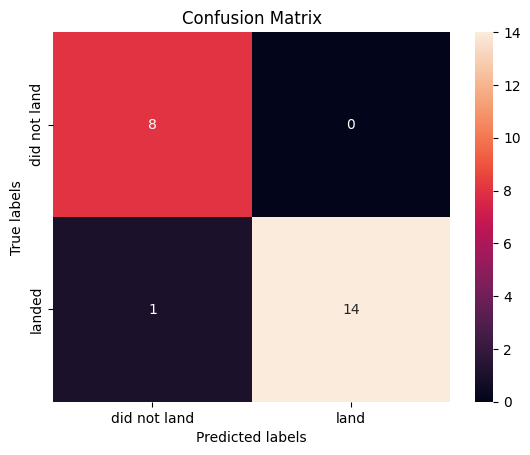

In [42]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Descision Trees


We create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  We fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [46]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [47]:
tree_cv = GridSearchCV(tree,parameters,cv=10)
tree_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [48]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.9857142857142858


We calculate the accuracy of `tree_cv` on the test data using the method <code>score</code>:


In [49]:
test_accuracy = tree_cv.score(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9130434782608695


We can plot the confusion matrix


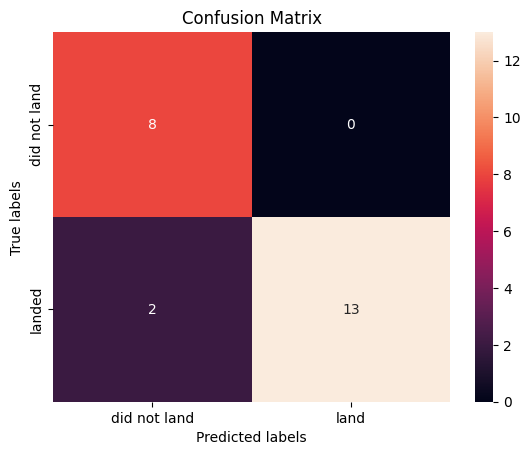

In [50]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## KNN


We create a `k` nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10. We fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [51]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [52]:
knn_cv = GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [53]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
accuracy : 0.892857142857143


We calculate the accuracy of `knn_cv` on the test data using the method <code>score</code>:


In [54]:
test_accuracy = knn_cv.score(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9130434782608695


We can plot the confusion matrix


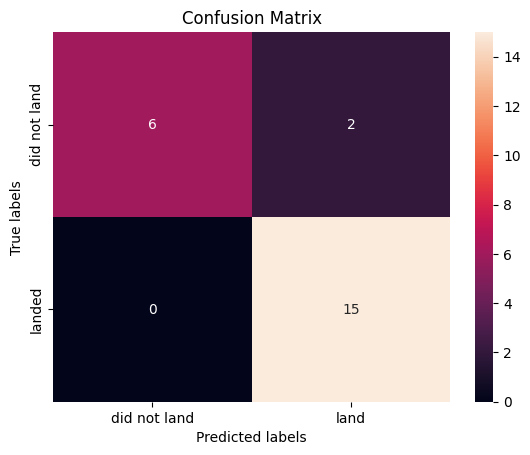

In [55]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Best Model


Here we compare the overall performance of each method based on the `Accuracy` metric:


(0.5, 1.0)

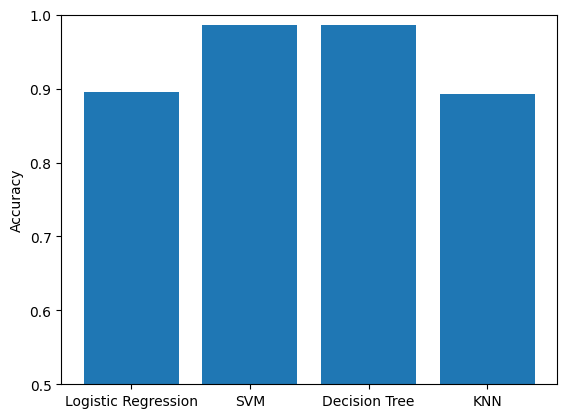

In [56]:
logreg_cv.best_score_
dir(logreg_cv)
plt.bar(['Logistic Regression','SVM','Decision Tree','KNN'],[logreg_cv.best_score_,svm_cv.best_score_,tree_cv.best_score_,knn_cv.best_score_])
plt.ylabel('Accuracy')
plt.ylim(0.5,1)

Overall, all grid-searched classifier models in this study provide fairly high accuracy exceeding 90%. In particular, the SVM and Decision Trees models exhibit the best performance in classifying the landing outcomes.
The obtained accuracy is significantly higher than the baseline 67% set by a NULL classifier that predicts a single class 1 for all observations. Therefore, our data required no special treatment for class imbalance.

Additionally, the data was well-organized and did not require cleaning. However, a notable limitation with this dataset is its small sample size, including approximately 100 observations.
and the importance of specific features might change compared to the findings of this analysis.

Please chech out my [GitHub](https://github.com/kkarimi62/IBM-Machine-Learning-Professional-Certificate.git) for further information.